In [1]:
from IPython.core.display import HTML, display
import pickle
from warnings import filterwarnings

import pymc3 as pm
import theano.tensor as tt
from theano import shared

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from seaborn import heatmap
import matplotlib.pyplot as pl
from matplotlib import rcParams
from cmocean import cm as cmo

from pymc_utils import PyMCModel
from pymc_utils import subset_significant_feature

In [2]:
filterwarnings('ignore', category=UserWarning)

In [3]:
display(HTML("<style>.container {width: 90% !important}</style>"))

In [4]:
% matplotlib inline
rcParams['axes.titlesize'] = 18
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.labelsize'] = 16
rcParams['font.size'] = 16

In [37]:
def bayes_nn_model_l1_h(X, y_obs, n_hidden=None, lklhd_name='likelihood',
                       parameterize_elu=False):
    """
    Hierarchical Bayesian NN Implementation with ARD.
    
    Inputs:
    --------
    X: theano shared variable,
    y_obs: numpy vector,
    n_hidden: number of hidden layer neurons,
    lklhd_name: name of the likelihood variable.
    
    Output:
    --------
    PyMC3 model
    """
    
    X = pm.floatX(X)
    Y = pm.floatX(y_obs)
    if hasattr(X, 'name'):
        num_obs, num_feats = X.eval().shape
    else:
        num_obs, num_feats = X.shape
    
    if n_hidden is None:
        n_hidden = num_feats
    
    with pm.Model() as model:
        
        
        if parameterize_elu:
            alpha_elu = pm.HalfCauchy('alpha_elu', beta=5)
        else:
            alpha_elu = 1
        elu_init_scale1 = np.sqrt(2) * np.sqrt(2 / (num_feats + n_hidden))
        elu_init_scale2 = np.sqrt(2) * np.sqrt(2 / (n_hidden + 1))
        
        
        hyp_wi1_sd = pm.HalfCauchy('hyp_w_i_1_sd', beta=5, shape=(num_feats,1))
        hyp_w1o_sd = pm.HalfCauchy('hyp_w_1_out_sd', beta=5)
        hyp_bias_1_sd = pm.HalfCauchy('hyp_bias_1_sd', beta=5)
        hyp_bias_o_sd = pm.HalfCauchy('hyp_bias_o_sd', beta=5)
         
        w_i_1_intrmd = pm.Normal('wts_i_1_intrmd', mu=0, sd=1, shape=(num_feats, n_hidden))
        w_1_o_intrmd = pm.Normal('wts_1_o_intrmd', mu=0, sd=1, shape=(n_hidden,))
        
        w_i_1 = pm.Deterministic('wts_i_1', w_i_1_intrmd * hyp_wi1_sd)
        w_1_o = pm.Deterministic('wts_1_out', w_1_o_intrmd * hyp_w1o_sd)
        b_1 = pm.Normal('bias_1', mu=-1, sd=hyp_bias_1_sd, shape=(n_hidden))
        b_o = pm.Normal('bias_o', mu=0, sd=hyp_bias_o_sd)
        lyr1_act = pm.Deterministic('layer1_act', tt.nnet.relu(tt.dot(X, w_i_1) + b_1) )
        out_act = pm.Deterministic('out_act', tt.dot(lyr1_act, w_1_o) + b_o)
        
        sd = pm.HalfCauchy('sd', beta=5)
        output = pm.Normal(lklhd_name, mu=out_act, sd=sd, observed=Y)
    return model

In [7]:
def plot_pairwise_corr(df_, ax=None, **heatmap_kwgs):
    if ax is None:
        _, ax = pl.subplots(figsize=(12, 10))
    heatmap(df_.corr().iloc[1:,:-1],vmin=-1, vmax=1,
            mask=np.triu(np.ones([df_.shape[1]-1] * 2),k=1),
            ax=ax, **heatmap_kwgs,
            #annot=True, annot_kws={'fontsize': 10}, cmap=cmo.balance_r
           )
    ax.set_facecolor('k')
    return ax

In [8]:
ds = pd.read_pickle('./pickleJar/OperationalDataSets/df_6_APHY_Standardized_SWF.pkl')
#ds['log10_aphy%d' % band] = np.log10(ds.loc[:, 'aphy%d' % band])
#ds.to_pickle('./pickleJar/OperationalDataSets/df_6_APHY_Standardized_SWF.pkl')

In [9]:
ds.describe().T

,count,mean,std,min,25%,50%,75%,max
sin_doy_s,162.0,-7.538551e-17,1.003101,-1.632361,-1.075398,0.291772,0.919767,1.067988
cos_doy_s,162.0,3.807825e-17,1.003101,-1.729100,-0.778317,0.208898,0.685304,1.430161
sin_minofday_s,162.0,1.915477e-16,1.003101,-0.599067,-0.553291,-0.397313,0.053463,4.165531
cos_minofday_s,162.0,-2.193033e-17,1.003101,-1.835295,-0.763772,0.101973,0.788677,2.063419
x_s,162.0,-1.045117e-16,1.003101,-2.523305,0.067800,0.101626,0.322978,2.480050
y_s,162.0,-6.030841e-17,1.003101,-0.570194,-0.540412,-0.281825,-0.081228,4.415726
z_s,162.0,-1.096945e-16,1.003101,-4.151014,0.121210,0.153920,0.480512,1.370943
log10_etopo2_s,162.0,-1.398059e-16,1.003101,-1.962412,-0.768789,-0.369002,0.760279,1.745110
oisst_s,162.0,2.193033e-17,1.003101,-2.990826,-0.781122,0.070849,0.976256,1.396973
solz_s,162.0,-1.072530e-16,1.003101,-1.851402,-0.753258,0.127265,0.760037,1.757741


In [10]:
aphys = ds.filter(regex='^aphy').columns.tolist()
ds.drop(aphys, axis=1, inplace=True)

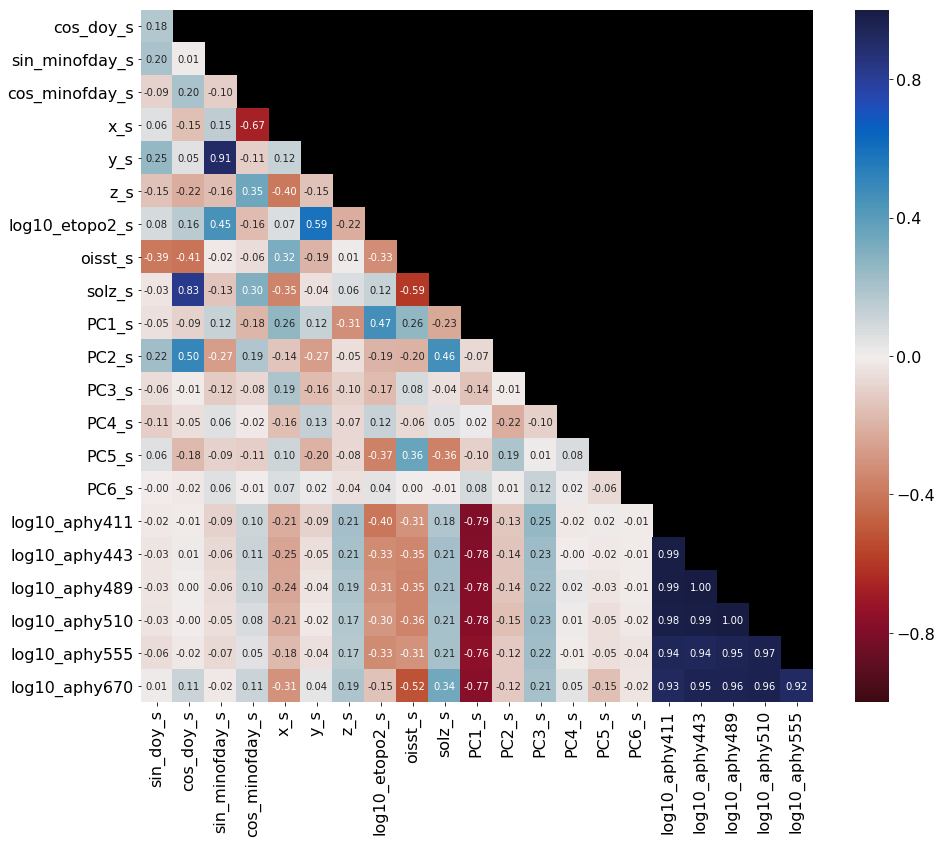

In [11]:
f, ax = pl.subplots(figsize=(14, 12))
plot_pairwise_corr(ds, ax=ax, annot=True, annot_kws=dict(fontsize=10), cmap=cmo.balance_r, fmt='.2f');
f.tight_layout()
f.savefig('/accounts/ekarakoy/WRITEUPS/TOA_ML_Writeup/FigJar/feature_heatmap_annotated.png', dpi=300)

In [12]:
feat_beg = 'sin_doy_s'
feat_end_ni = 'PC6_s'

X_s = ds.dropna().loc[:, :feat_end_ni]
lbls_X_s = X_s.columns.tolist()
y = ds.dropna().filter(regex='log10_aphy')

In [13]:
X_s_train, X_s_test, y_train, y_test = train_test_split(X_s, y, test_size=0.1,
                                                       random_state=42)
Xy_train = pd.concat((X_s_train, y_train), axis=1)

### Fitting w/ All Features

####  <u>Model 1: Single Layer BNN -- 4-unit HL</u>

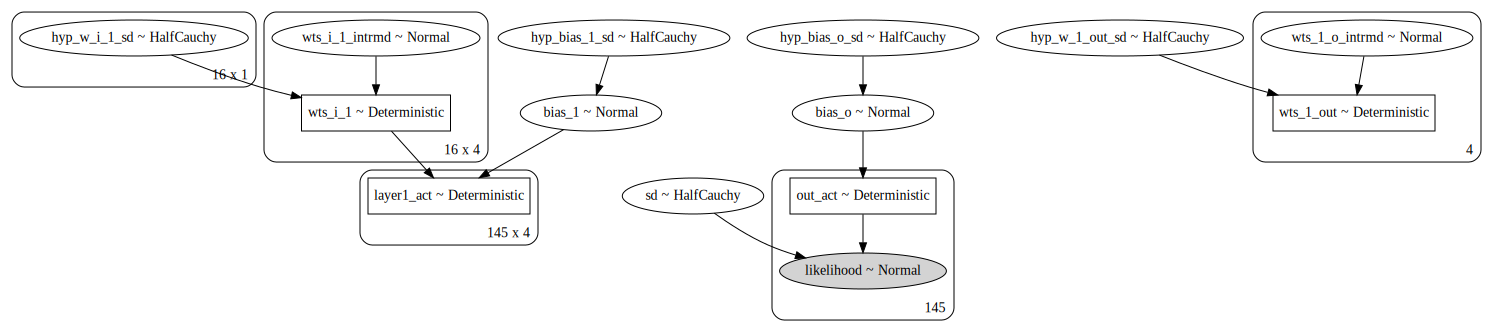

In [16]:
X_shared = shared(X_s_train.values)
bnn_l1_4HL_411 = PyMCModel(bayes_nn_model_l1_h, X_shared, y_train.log10_aphy411, n_hidden=4,)
bnn_l1_4HL_411.show_model()

In [17]:
bnn_l1_4HL_411.fit(n_samples=2000, cores=1, chains=1, tune=2500,  nuts_kwargs=dict(target_accept=0.9,max_treedepth=11))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sd, bias_o, bias_1, wts_1_o_intrmd, wts_i_1_intrmd, hyp_bias_o_sd, hyp_bias_1_sd, hyp_w_1_out_sd, hyp_w_i_1_sd]
100%|██████████| 4500/4500 [06:47<00:00, 11.04it/s]
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [18]:
bnn_l1_4HL_411.trace_.get_sampler_stats('depth').max()

10

In [ ]:
pm.fit()

In [38]:
bnn_l1_4HL_411.fit_ADVI(n_iter=50000, inference='svgd')

100%|██████████| 50000/50000 [08:00<00:00, 104.10it/s]


In [15]:
bnn_l1_4HL_411.fit_ADVI(n_iter=50000, inference='fullrank_advi')

  0%|          | 0/50000 [00:00<?, ?it/s]/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/theano/tensor/subtensor.py:2320: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/theano/tensor/subtensor.py:2190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureW

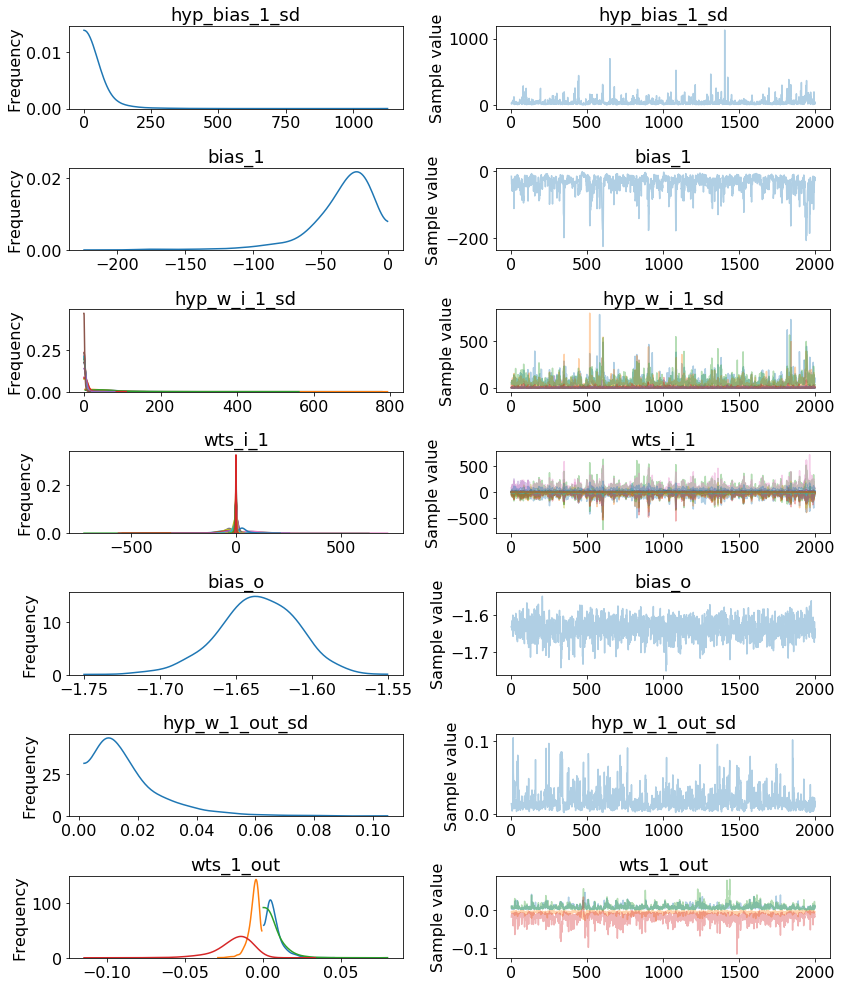

In [18]:
bnn_l1_4HL_411.evaluate_fit(['hyp_bias_1_sd', 'bias_1', 'hyp_w_i_1_sd','wts_i_1', 'bias_o', 'hyp_w_1_out_sd', 'wts_1_out']);

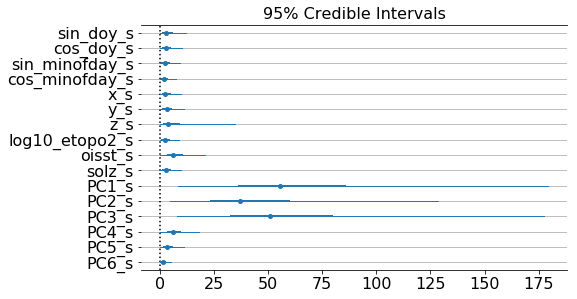

In [20]:
labels = ['%s' %li for li in lbls_X_s ]
bnn_l1_4HL_411.show_forest(['hyp_w_i_1_sd'], feat_labels=labels)
f = pl.gcf()
f.set_figwidth(8);
#a = pl.gca()
#a.set_xscale('log')

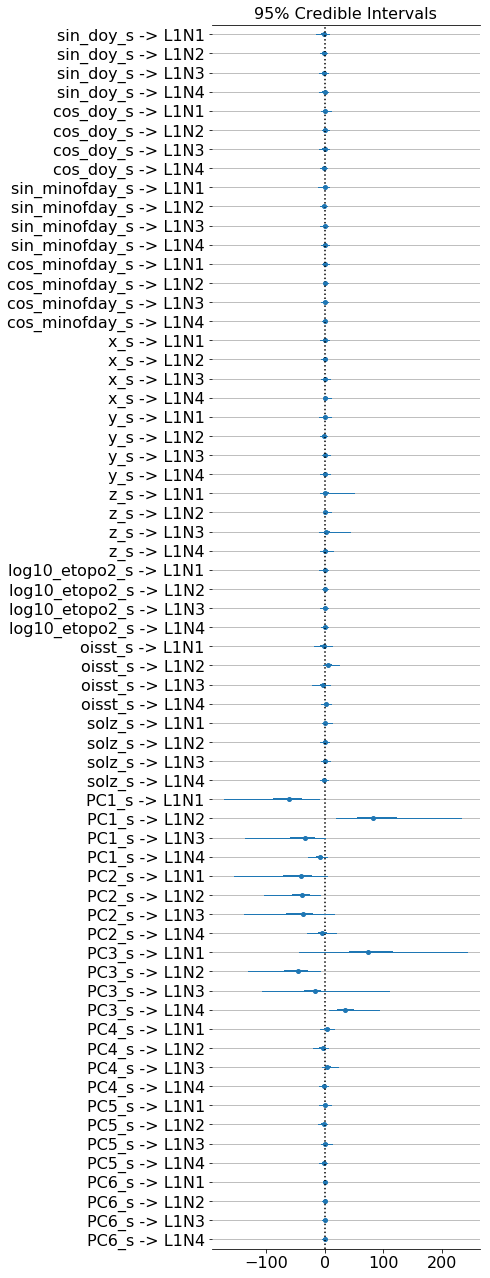

In [68]:
labels = ['%s -> L1N%d' %(li, ni) for li in lbls_X_s for ni in range(1, 5)]
bnn_l1_4HL_411.show_forest(['wts_i_1'], feat_labels=labels)
f = pl.gcf()
f.set_figheight(20);
f.savefig('./figJar/bnn_l1_4HL_411_wts_i_1_interp.pdf', dpi=300, format='pdf')

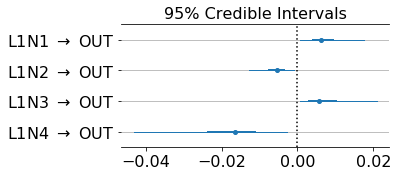

In [67]:
labels = [r'L1N%d $\rightarrow$ OUT' %ni for ni in range(1, 5)]
bnn_l1_4HL_411.show_forest(['wts_1_out'], feat_labels=labels)
f = pl.gcf()
f.set_figheight(2);

100%|██████████| 2000/2000 [00:01<00:00, 1129.85it/s]


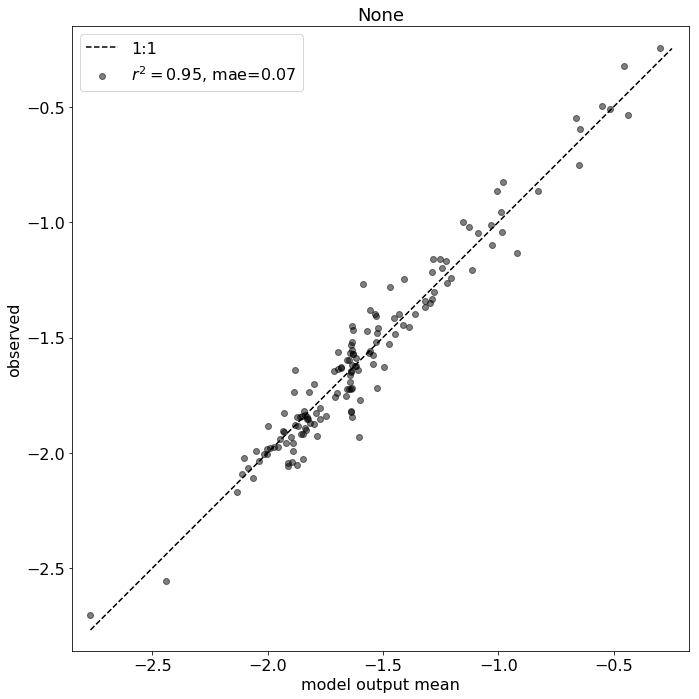

In [23]:
# Check fit on training model
X_shared.set_value(X_s_train)
ppc_train_l1_411 = bnn_l1_4HL_411.predict(likelihood_name='likelihood')
f, 
bnn_l1_4HL_411.plot_model_fits(y_train.log10_aphy411, ppc_train_l1_411, loss_metric='mae', );

100%|██████████| 2000/2000 [00:02<00:00, 875.25it/s]


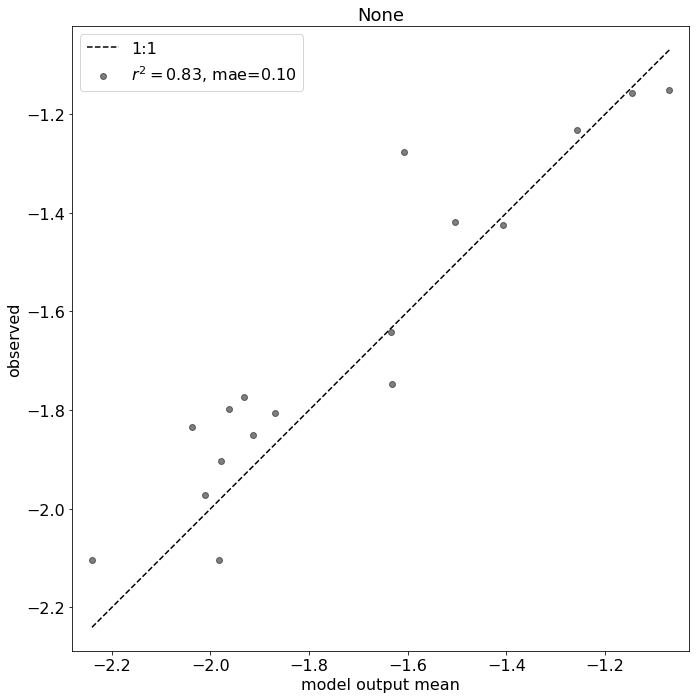

In [59]:
# Check Fit on Test Data
X_shared.set_value(X_s_test.values)
ppc_test_411 = bnn_l1_4HL_411.predict(likelihood_name='likelihood')
bnn_l1_4HL_411.plot_model_fits(y_test.log10_aphy411, ppc_test_411, loss_metric='mae',)

In [25]:
def plot_fits_w_estimates(y_obs, ppc, ax=None, savename=False):
    """ Plot Fits with Uncertainty Estimates"""
    iy  = np.argsort(y_obs)
    ix = np.arange(iy.size)
    lik_mean =ppc.mean(axis=0)
    lik_hpd = pm.hpd(ppc)
    lik_hpd_05 = pm.hpd(ppc, alpha=0.5)
    if ax is None:
        _, ax = pl.subplots(figsize=(12, 8))
    ax.scatter(ix, y_obs.values[iy], label='observed', edgecolor='k', s=100,
               color='steelblue', marker='d', zorder=2);
    ax.scatter(ix, lik_mean[iy], label='modeled', edgecolor='k', s=100, color='orange', zorder=3)

    ax.fill_between(ix, y1=lik_hpd_05[iy, 0], y2=lik_hpd_05[iy, 1], color='gray', 
                   label='model output 50%CI', zorder=1,linestyle='-', lw=2, edgecolor='k');
    ax.fill_between(ix, y1=lik_hpd[iy, 0], y2=lik_hpd[iy, 1], color='k', alpha=0.75,
                   label='model output 95%CI', zorder=0, );
    ax.legend(loc='upper left');
    if savename:
        f = pl.gcf()
        f.savefig('./figJar/bayesNet/bNN_L1_nobias.pdf', format='pdf')
    return ax

### A$\phi$_443

INFO (theano.gof.compilelock): Waiting for existing lock by process '28978' (I am process '28065')
INFO (theano.gof.compilelock): To manually release the lock, delete /accounts/ekarakoy/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.6-64/lock_dir


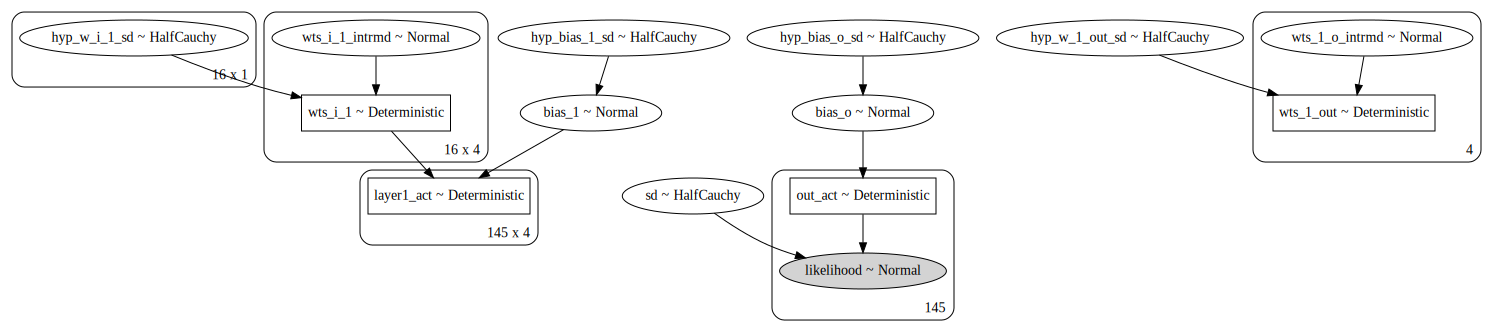

In [26]:
X_shared = shared(X_s_train.values)
bnn_l1_4HL_443 = PyMCModel(bayes_nn_model_l1_h, X_shared, y_train.log10_aphy443, n_hidden=4,)
bnn_l1_4HL_443.show_model()

In [27]:
bnn_l1_4HL_443.fit(n_samples=2000, cores=1, chains=1, tune=2500,  nuts_kwargs=dict(target_accept=0.95,max_treedepth=11))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sd, bias_o, bias_1, wts_1_o_intrmd, wts_i_1_intrmd, hyp_bias_o_sd, hyp_bias_1_sd, hyp_w_1_out_sd, hyp_w_i_1_sd]
100%|██████████| 4500/4500 [15:29<00:00,  4.84it/s]
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


100%|██████████| 2000/2000 [00:01<00:00, 1130.01it/s]


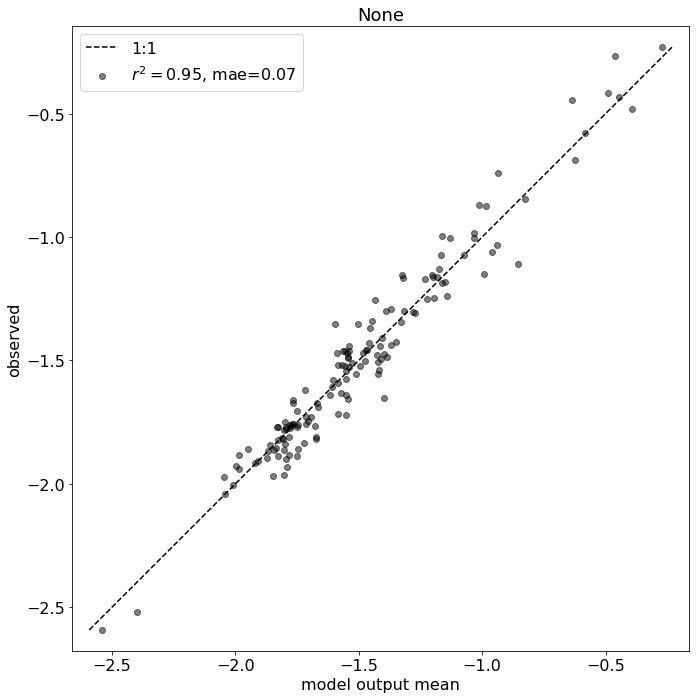

In [28]:
# Check fit on training model
X_shared.set_value(X_s_train)
ppc_train_l1_443 = bnn_l1_4HL_443.predict(likelihood_name='likelihood')
bnn_l1_4HL_443.plot_model_fits(y_train.log10_aphy443, ppc_train_l1_443, loss_metric='mae', );

100%|██████████| 2000/2000 [00:02<00:00, 859.75it/s]


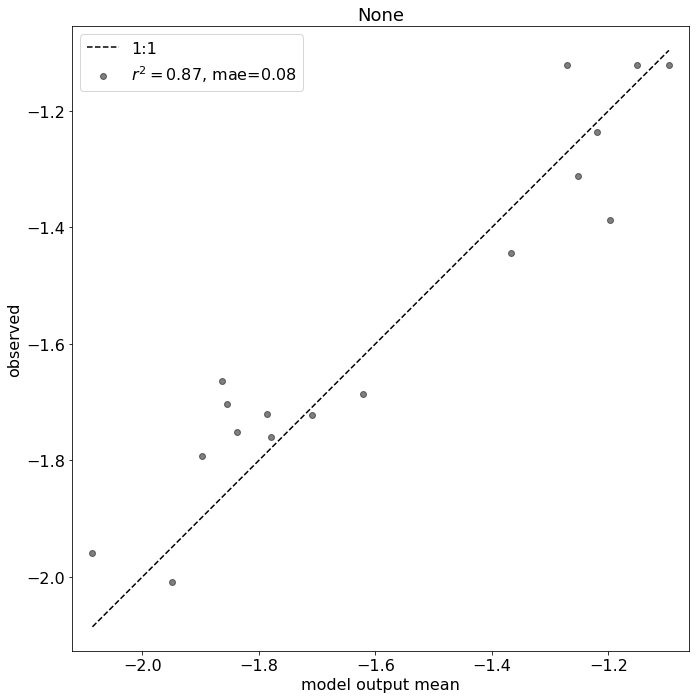

In [29]:
# Check Fit on Test Data
X_shared.set_value(X_s_test.values)
ppc_test_443 = bnn_l1_4HL_443.predict(likelihood_name='likelihood')
bnn_l1_4HL_443.plot_model_fits(y_test.log10_aphy443, ppc_test_443, loss_metric='mae',)

In [30]:
def plot_obs_against_ppc(y_obs, ppc, ax=None, plot_1_to_1=False, **scatter_kwds):
    if ax is None:
        _, ax = pl.subplots(figsize=(10, 10))
    ppc_mean = ppc.mean(axis=0)
    ax.scatter(y_obs, ppc_mean, edgecolor='k', **scatter_kwds)
    if plot_1_to_1:
        min_ = min(ppc_mean.min(), y_obs.min())
        max_ = max(ppc_mean.max(), y_obs.max())
        ax.plot([min_, max_], [min_, max_], ls='--', color='k', label='1:1')
    

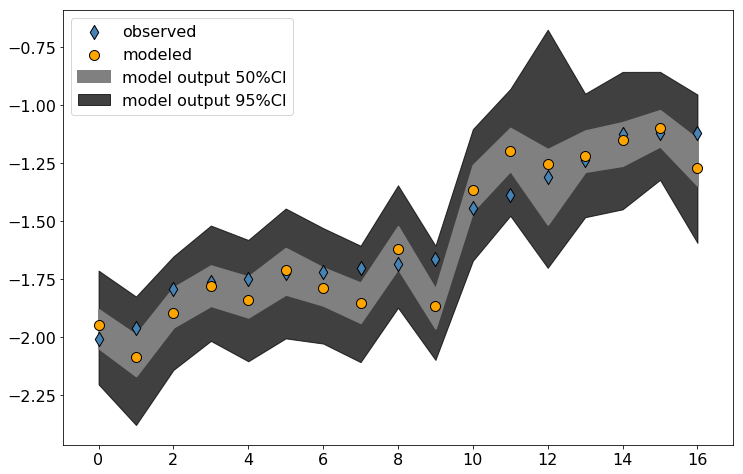

In [31]:
ax = plot_fits_w_estimates(y_test.log10_aphy443, ppc_test_443)


### A$\phi$_489

In [32]:
X_shared = shared(X_s_train.values)
bnn_l1_4HL_489 = PyMCModel(bayes_nn_model_l1_h, X_shared, y_train.log10_aphy489, n_hidden=4,)

In [33]:
bnn_l1_4HL_489.fit(n_samples=2000, cores=1, chains=1, tune=2500,  nuts_kwargs=dict(target_accept=0.95,max_treedepth=11))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sd, bias_o, bias_1, wts_1_o_intrmd, wts_i_1_intrmd, hyp_bias_o_sd, hyp_bias_1_sd, hyp_w_1_out_sd, hyp_w_i_1_sd]
100%|██████████| 4500/4500 [12:24<00:00,  6.05it/s]
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


100%|██████████| 2000/2000 [00:01<00:00, 1173.93it/s]


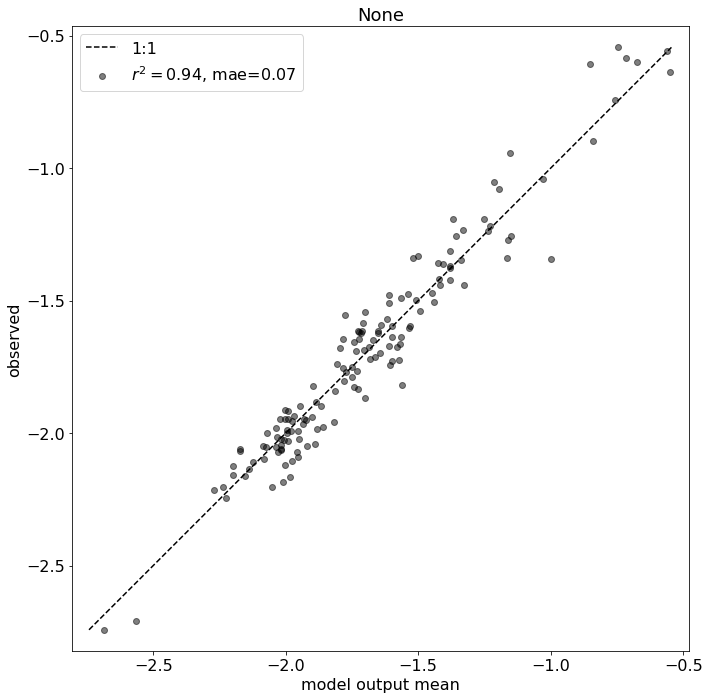

In [34]:
# Check fit on training model
X_shared.set_value(X_s_train)
ppc_train_l1_489 = bnn_l1_4HL_489.predict(likelihood_name='likelihood')
bnn_l1_4HL_489.plot_model_fits(y_train.log10_aphy489, ppc_train_l1_489, loss_metric='mae', );

100%|██████████| 2000/2000 [00:02<00:00, 901.38it/s]


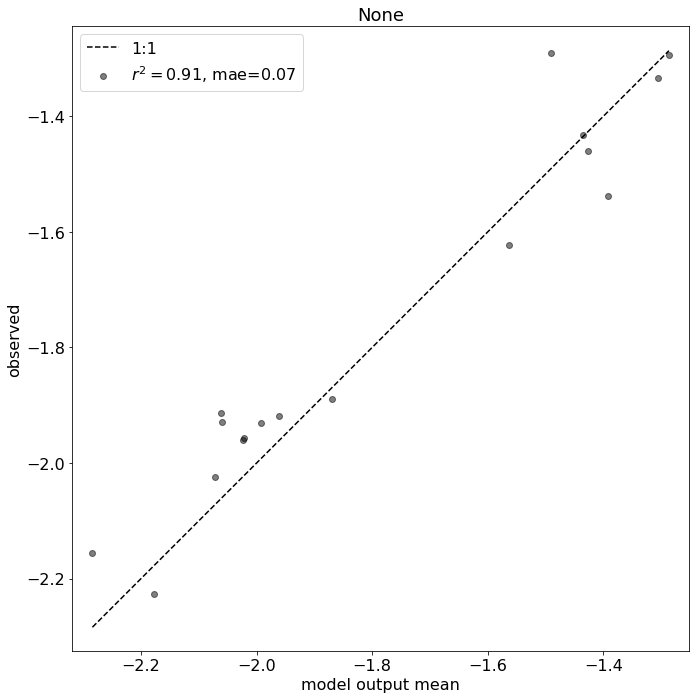

In [35]:
# Check Fit on Test Data
X_shared.set_value(X_s_test.values)
ppc_test_489 = bnn_l1_4HL_489.predict(likelihood_name='likelihood')
bnn_l1_4HL_489.plot_model_fits(y_test.log10_aphy489, ppc_test_489, loss_metric='mae',)

### A$\phi$_510

In [36]:
X_shared = shared(X_s_train.values)
bnn_l1_4HL_510 = PyMCModel(bayes_nn_model_l1_h, X_shared, y_train.log10_aphy510, n_hidden=4,)
bnn_l1_4HL_510.fit(n_samples=2000, cores=1, chains=1, tune=2500,  nuts_kwargs=dict(target_accept=0.95,max_treedepth=11))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sd, bias_o, bias_1, wts_1_o_intrmd, wts_i_1_intrmd, hyp_bias_o_sd, hyp_bias_1_sd, hyp_w_1_out_sd, hyp_w_i_1_sd]
100%|██████████| 4500/4500 [16:52<00:00,  4.44it/s]
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


100%|██████████| 2000/2000 [00:01<00:00, 1042.89it/s]


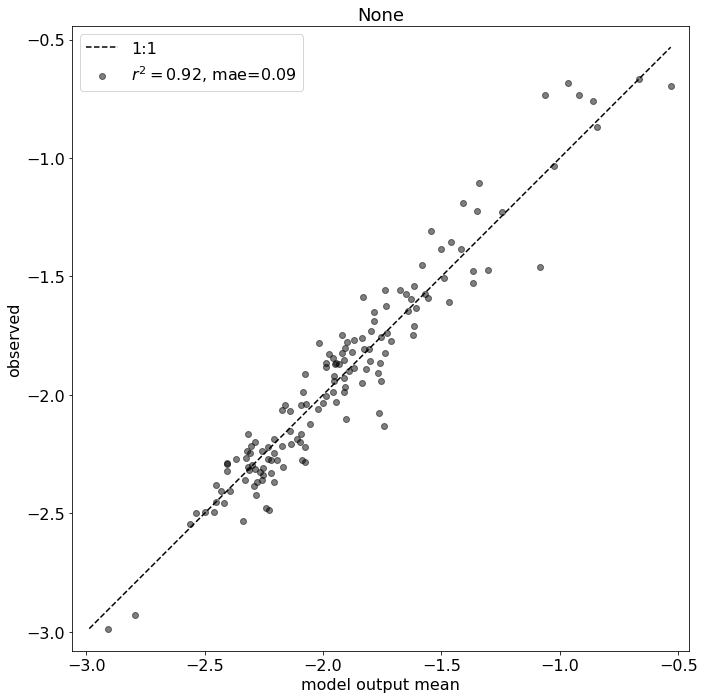

In [38]:
# Check fit on training model
X_shared.set_value(X_s_train)
ppc_train_l1_510 = bnn_l1_4HL_510.predict(likelihood_name='likelihood')
bnn_l1_4HL_510.plot_model_fits(y_train.log10_aphy510, ppc_train_l1_510, loss_metric='mae', );

100%|██████████| 2000/2000 [00:02<00:00, 845.78it/s]


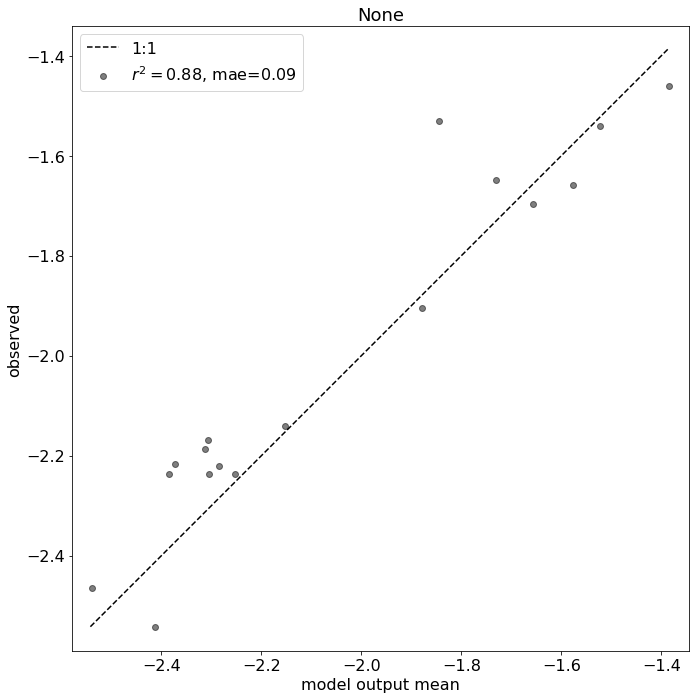

In [39]:
# Check Fit on Test Data
X_shared.set_value(X_s_test.values)
ppc_test_510 = bnn_l1_4HL_510.predict(likelihood_name='likelihood')
bnn_l1_4HL_510.plot_model_fits(y_test.log10_aphy510, ppc_test_510, loss_metric='mae',)

### A$\phi$555

In [40]:
X_shared = shared(X_s_train.values)
bnn_l1_4HL_555 = PyMCModel(bayes_nn_model_l1_h, X_shared, y_train.log10_aphy555, n_hidden=4,)
bnn_l1_4HL_555.fit(n_samples=2000, cores=1, chains=1, tune=2500,  nuts_kwargs=dict(target_accept=0.95,max_treedepth=11))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sd, bias_o, bias_1, wts_1_o_intrmd, wts_i_1_intrmd, hyp_bias_o_sd, hyp_bias_1_sd, hyp_w_1_out_sd, hyp_w_i_1_sd]
100%|██████████| 4500/4500 [10:38<00:00,  7.05it/s]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


100%|██████████| 2000/2000 [00:01<00:00, 1096.70it/s]


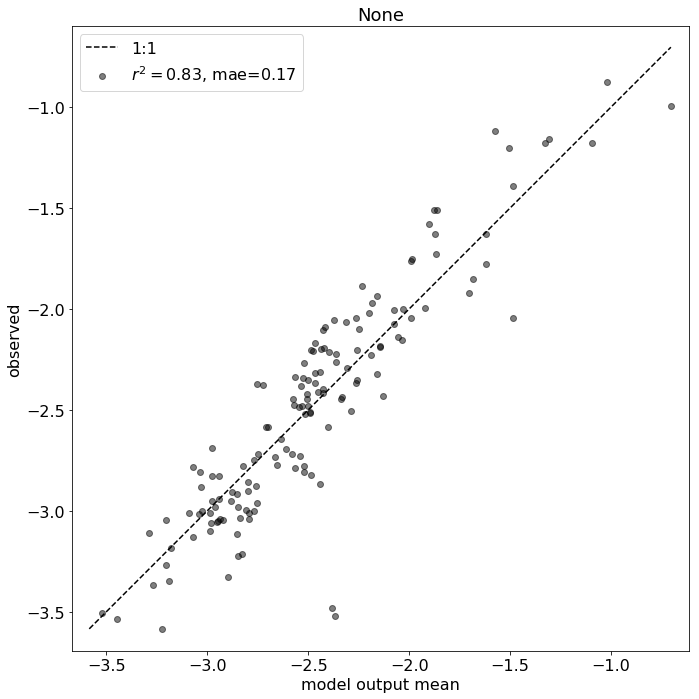

In [41]:
# Check fit on training model
X_shared.set_value(X_s_train)
ppc_train_l1_555 = bnn_l1_4HL_555.predict(likelihood_name='likelihood')
bnn_l1_4HL_555.plot_model_fits(y_train.log10_aphy555, ppc_train_l1_555, loss_metric='mae', );

100%|██████████| 2000/2000 [00:02<00:00, 794.35it/s]


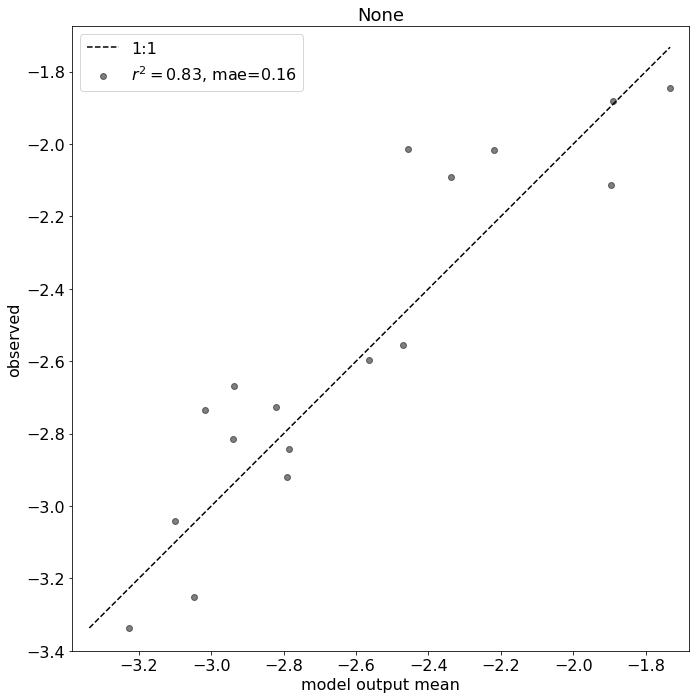

In [42]:
# Check Fit on Test Data
X_shared.set_value(X_s_test.values)
ppc_test_555 = bnn_l1_4HL_555.predict(likelihood_name='likelihood')
bnn_l1_4HL_555.plot_model_fits(y_test.log10_aphy555, ppc_test_555, loss_metric='mae',)

### A$\phi$ 670

In [44]:
X_shared = shared(X_s_train.values)
bnn_l1_4HL_670 = PyMCModel(bayes_nn_model_l1_h, X_shared, y_train.log10_aphy670, n_hidden=4,)
bnn_l1_4HL_670.fit(n_samples=2000, cores=1, chains=1, tune=2500,  nuts_kwargs=dict(max_treedepth=11))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sd, bias_o, bias_1, wts_1_o_intrmd, wts_i_1_intrmd, hyp_bias_o_sd, hyp_bias_1_sd, hyp_w_1_out_sd, hyp_w_i_1_sd]
100%|██████████| 4500/4500 [06:39<00:00, 11.27it/s]
There were 117 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


100%|██████████| 2000/2000 [00:01<00:00, 1065.68it/s]


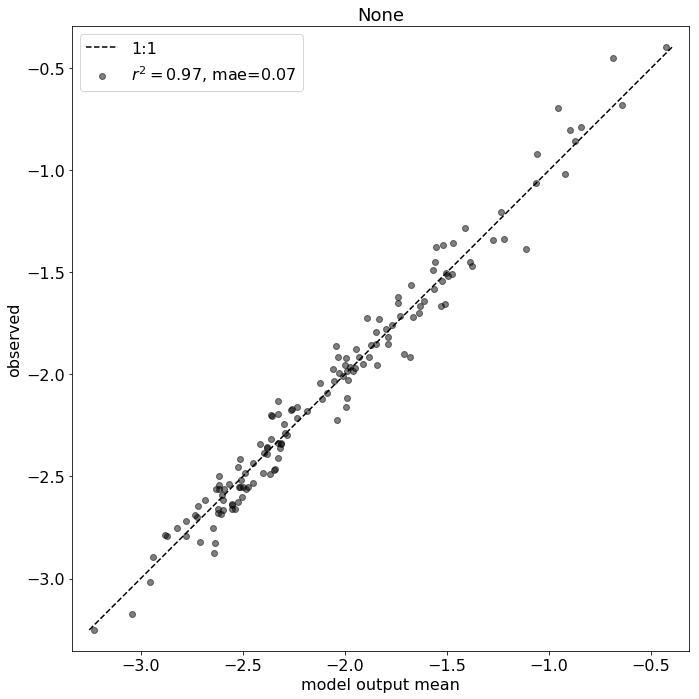

In [45]:
# Check fit on training model
X_shared.set_value(X_s_train)
ppc_train_l1_670 = bnn_l1_4HL_670.predict(likelihood_name='likelihood')
bnn_l1_4HL_670.plot_model_fits(y_train.log10_aphy670, ppc_train_l1_670, loss_metric='mae', );

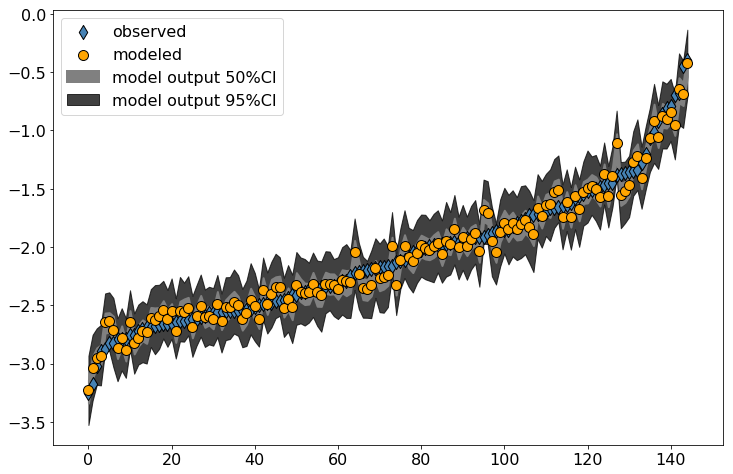

In [46]:
plot_fits_w_estimates(y_train.log10_aphy670, ppc_train_l1_670)

100%|██████████| 2000/2000 [00:02<00:00, 834.20it/s]


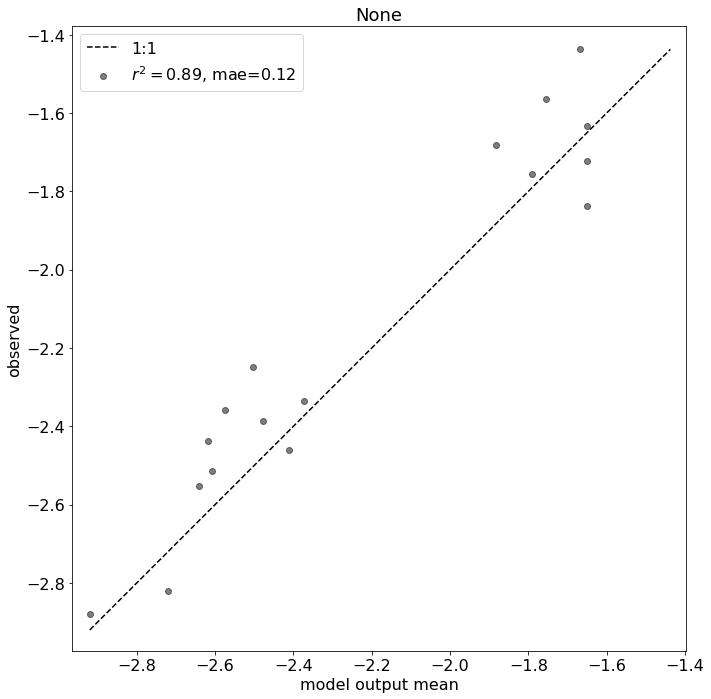

In [47]:
# Check fit on training model
X_shared.set_value(X_s_test)
ppc_test_670 = bnn_l1_4HL_670.predict(likelihood_name='likelihood')
bnn_l1_4HL_670.plot_model_fits(y_test.log10_aphy670, ppc_test_670, loss_metric='mae', );

### Summary Graphs

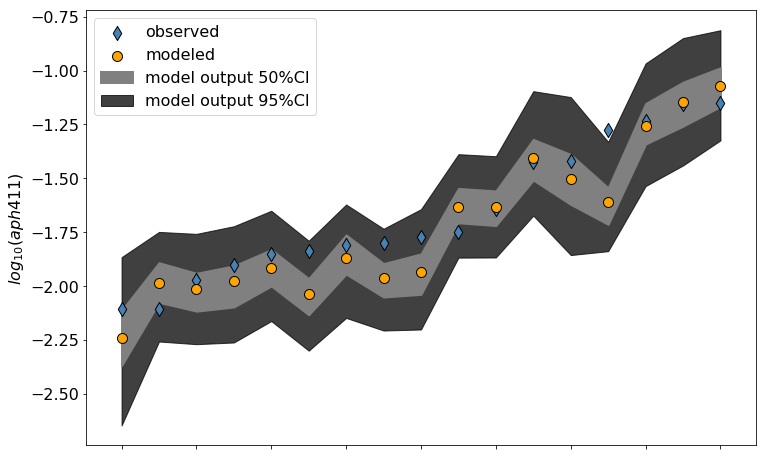

In [75]:
ax = plot_fits_w_estimates(y_test.log10_aphy411, ppc_test_411)
ax.set_xticklabels([]);
ax.set_ylabel('$log_{10}(aph 411)$')
f = pl.gcf()
f.savefig('./figJar/Single_HL_4_aphi_411_unc.pdf', dpi=300, format='pdf')

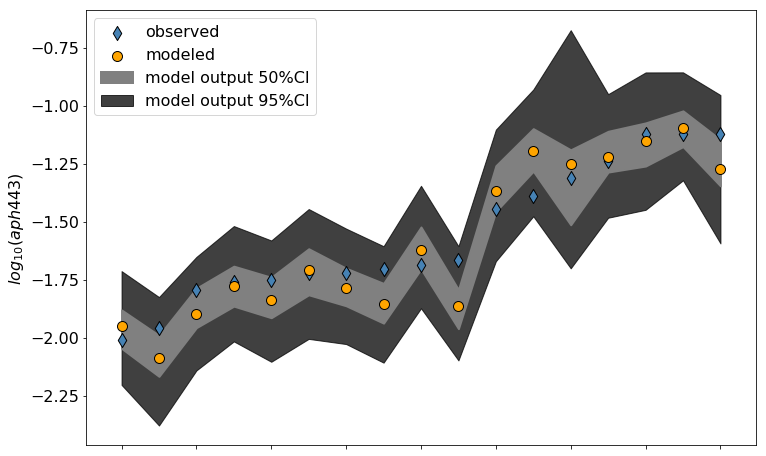

In [74]:
ax = plot_fits_w_estimates(y_test.log10_aphy443, ppc_test_443)
ax.set_xticklabels([]);
ax.set_ylabel('$log_{10}(aph 443)$')
f = pl.gcf()
f.savefig('./figJar/Single_HL_4_aphi_443_unc.pdf', dpi=300, format='pdf')

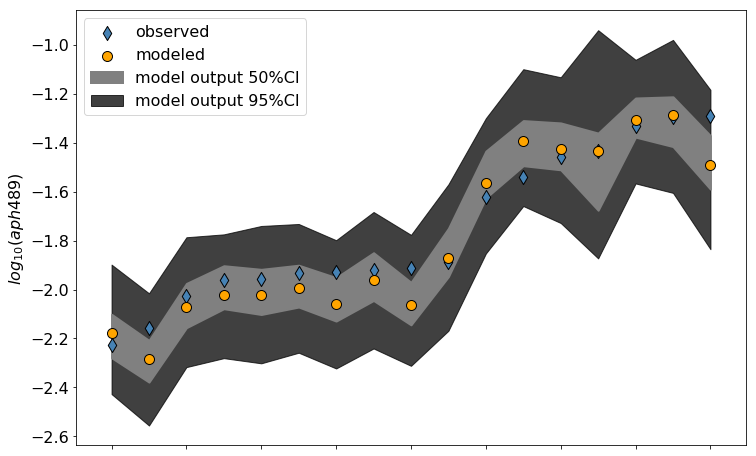

In [73]:
ax = plot_fits_w_estimates(y_test.log10_aphy489, ppc_test_489)
ax.set_xticklabels([]);
ax.set_ylabel('$log_{10}(aph 489)$')
f = pl.gcf()
f.savefig('./figJar/Single_HL_4_aphi_489_unc.pdf', dpi=300, format='pdf')

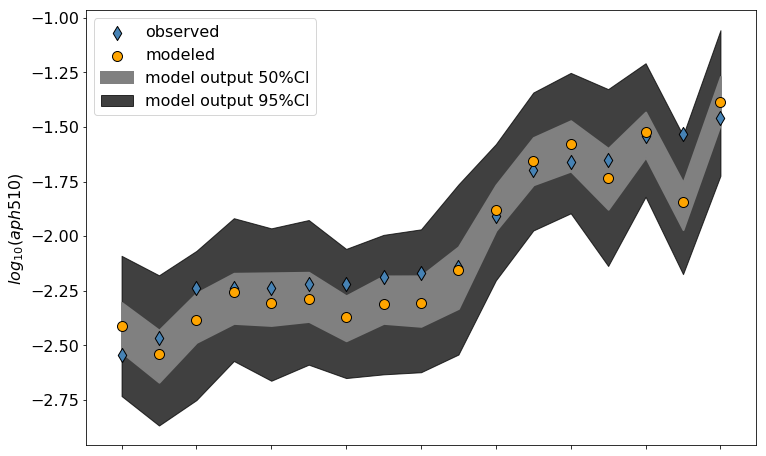

In [72]:
ax = plot_fits_w_estimates(y_test.log10_aphy510, ppc_test_510)
ax.set_xticklabels([]);
ax.set_ylabel('$log_{10}(aph 510)$')
f = pl.gcf()
f.savefig('./figJar/Single_HL_4_aphi_510_unc.pdf', dpi=300, format='pdf')

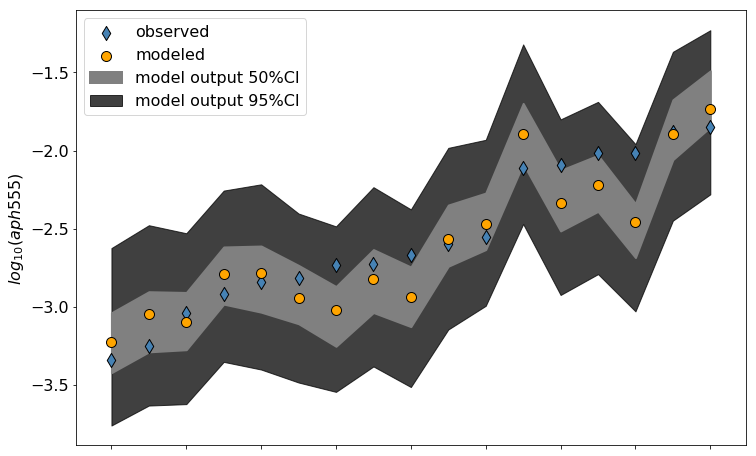

In [71]:
ax = plot_fits_w_estimates(y_test.log10_aphy555, ppc_test_555)
ax.set_xticklabels([]);
ax.set_ylabel('$log_{10}(aph 555)$')
f = pl.gcf()
f.savefig('./figJar/Single_HL_4_aphi_555_unc.pdf', dpi=300, format='pdf')

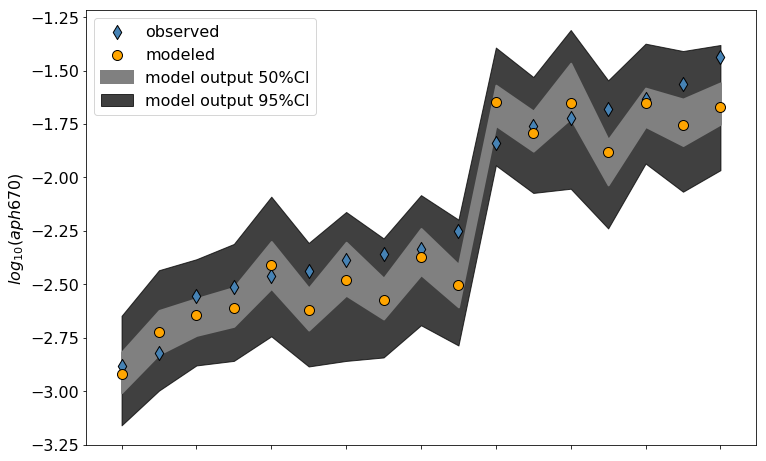

In [69]:
ax = plot_fits_w_estimates(y_test.log10_aphy670, ppc_test_670)
ax.set_xticklabels([]);
ax.set_ylabel('$log_{10}(aph 670)$')
f = pl.gcf()
f.savefig('./figJar/Single_HL_4_aphi_670_unc.pdf', dpi=300, format='pdf')

In [57]:
def uncertainty_plot_2(ppc_train, ppc_test, y_test_, y_train_, ax, band_color,
                      scatter_zorder=2, hpd_zorder=0, hpd_50_zorder=1):
    ix_ = np.argsort(y_train_)
    hpd_50 = pm.hpd(ppc_train[:, ix_], alpha=0.5)
    hpd = pm.hpd(ppc_train[:, ix_],)
    mean_ = ppc_train[:, ix_].mean(axis=0)
    mean_test_ = ppc_test.mean(axis=0)
    ax.scatter(mean_test_, y_test_, edgecolor='k', lw=2, zorder=scatter_zorder, color=band_color, s=50)
    ax.fill_betweenx(mean_, x1=hpd[:, 0], x2=hpd[:, 1], alpha=0.25, zorder=hpd_zorder, color=band_color)
    ax.fill_betweenx(mean_, x1=hpd_50[:, 0], x2=hpd_50[:, 1], alpha=0.25, color=band_color)

In [213]:
hpd_670_50 = pm.hpd(ppc_train_l1_670, alpha=0.5)
hpd_670 = pm.hpd(ppc_train_l1_670)
mn_670 = ppc_train_l1_670.mean(axis=0)
mn_670_test = ppc_test_670.mean(axis=0)
ix = np.argsort(y_train.log10_aphy670)

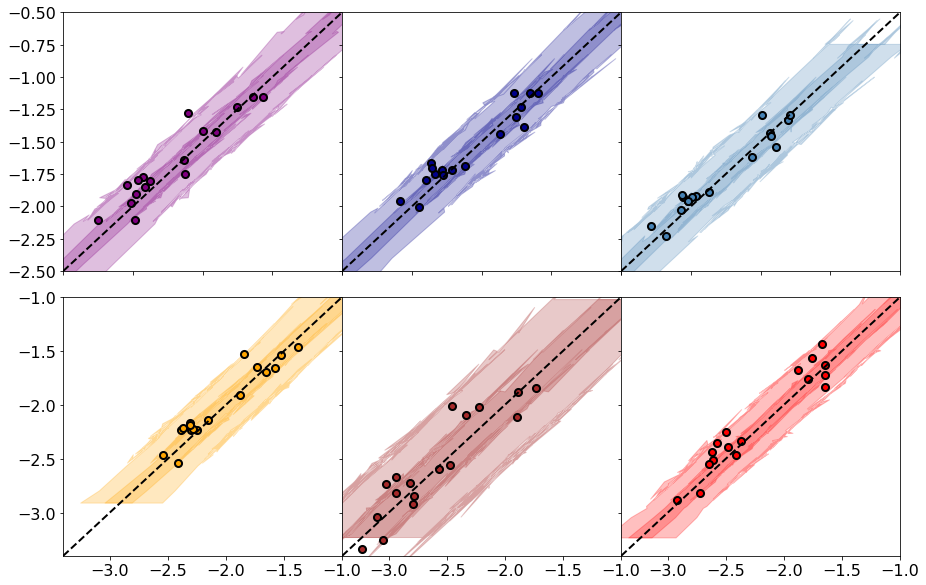

In [58]:
f, axs = pl.subplots(nrows=2, ncols=3, figsize=(15, 10))
axs = axs.ravel()
f.subplots_adjust(wspace=0, hspace=0.1)

uncertainty_plot_2(ppc_train_l1_411, ppc_test_411, y_test.log10_aphy411.values, y_train.log10_aphy411.values,
                  ax=axs[0], band_color='purple')
uncertainty_plot_2(ppc_train_l1_443, ppc_test_443, y_test.log10_aphy443.values, y_train.log10_aphy443.values,
                  ax=axs[1], band_color='darkblue')
uncertainty_plot_2(ppc_train_l1_489, ppc_test_489, y_test.log10_aphy489.values, y_train.log10_aphy489.values,
                  ax=axs[2], band_color='steelblue')
uncertainty_plot_2(ppc_train_l1_510, ppc_test_510, y_test.log10_aphy510.values, y_train.log10_aphy510.values,
                  ax=axs[3], band_color='orange')
uncertainty_plot_2(ppc_train_l1_555, ppc_test_555, y_test.log10_aphy555.values, y_train.log10_aphy555.values,
                  ax=axs[4], band_color='brown')
uncertainty_plot_2(ppc_train_l1_670, ppc_test_670, y_test.log10_aphy670.values, y_train.log10_aphy670.values,
                  ax=axs[5], band_color='red')
for i, ax in enumerate(axs):
    
    if i < 3:
        min_, max_ = -2.5, -0.5
        ax.set_xticklabels([])
    else:
        min_, max_ = -3.4, -1
    if i %3 != 0:
        ax.set_yticklabels([])
    ax.plot([min_, max_], [min_, max_], ls='--', color='k', lw=2, label='')
    ax.set_xlim(min_, max_)
    ax.set_ylim(min_, max_)

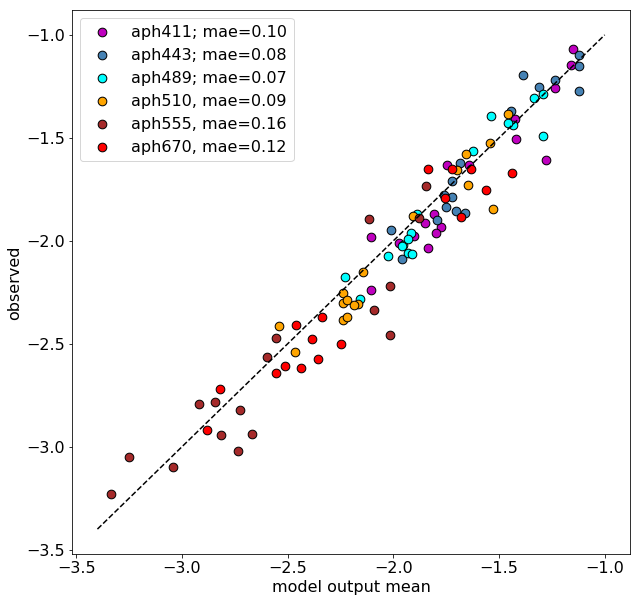

In [60]:
f, ax_ = pl.subplots(figsize=(10, 10))
plot_obs_against_ppc(y_test.log10_aphy411, ppc_test_411, color='m', label='aph411; mae=0.10', s=75, ax=ax_) 
plot_obs_against_ppc(y_test.log10_aphy443, ppc_test_443, color='steelblue', ax=ax_, label='aph443; mae=0.08', s=75,)
plot_obs_against_ppc(y_test.log10_aphy489, ppc_test_489, color='cyan', ax=ax_, label='aph489; mae=0.07', s=75, )
plot_obs_against_ppc(y_test.log10_aphy510, ppc_test_510, color='orange', ax=ax_, label='aph510, mae=0.09', s=75,)
plot_obs_against_ppc(y_test.log10_aphy555, ppc_test_555, color='brown', ax=ax_, label='aph555, mae=0.16', s=75, )
plot_obs_against_ppc(y_test.log10_aphy670, ppc_test_670, color='red', ax=ax_, label='aph670, mae=0.12', s=75, )
ax_.plot([-3.4, -1], [-3.4, -1], color='k', ls='--')
ax_.legend()
ax_.set_xlabel('model output mean')
ax_.set_ylabel('observed')
f.savefig('./figJar/Single_HL_4_aphi_test_sets.pdf', format='pdf', dpi=300)

In [61]:
bnn_l1_4HL_411.model.name = 'bnn_l1_4HL_411'
bnn_l1_4HL_443.model.name = 'bnn_l1_4HL_443'
bnn_l1_4HL_489.model.name = 'bnn_l1_4HL_489'
bnn_l1_4HL_510.model.name = 'bnn_l1_4HL_510'
bnn_l1_4HL_555.model.name = 'bnn_l1_4HL_555'
bnn_l1_4HL_670.model.name = 'bnn_l1_4HL_670'

In [62]:
pickledModelDict = {bnn_l1_4HL_411.model.name: 'bnn_l1_4HL_411',
                    bnn_l1_4HL_443.model.name: 'bnn_l1_4HL_443',
                    bnn_l1_4HL_489.model.name: 'bnn_l1_4HL_489',
                    bnn_l1_4HL_510.model.name: 'bnn_l1_4HL_510',
                    bnn_l1_4HL_555.model.name: 'bnn_l1_4HL_555',
                    bnn_l1_4HL_670.model.name: 'bnn_l1_4HL_670'
                   }
with open('./pickleJar/Models/Aphi_ALL_BNN_4_HL1_ARD.pkl', 'wb') as f:
    pickle.dump(pickledModelDict, f, protocol=pickle.HIGHEST_PROTOCOL)